# Análisis Histórico del Fútbol Argentino
Bienvenido a este notebook profesional! Aquí analizamos datos de partidos desde 1931 hasta 2020. Incluye limpieza, rankings y visualizaciones épicas.
Datos: results.csv (historial de la liga argentina).
## Preparación: Importar librerías y cargar datos

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

# Cargar el CSV
ruta = '/content/drive/MyDrive/results.csv'
df = pd.read_csv(ruta)

# Renombrar columnas a español
df = df.rename(columns={
    'Unnamed: 0': 'id_partido',
    'date_name': 'torneo_fecha',
    'local_team_id': 'id_local',
    'local_team': 'equipo_local',
    'local_result': 'goles_local',
    'visitor_result': 'goles_visitante',
    'visitor_team': 'equipo_visitante',
    'visitor_team_id': 'id_visitante'
})

# Eliminar columna innecesaria
df = df.drop(columns=['id_partido'], errors=['ignore'])

# Mostrar primeras filas
df.head()

Mounted at /content/drive


,torneo_fecha,id_local,equipo_local,goles_local,goles_visitante,equipo_visitante,id_visitante
0,Nacional 1976 - Grupo C,1,All Boys,2,0,Aldosivi,0
1,Nacional 1976 - Grupo C,0,Aldosivi,4,0,All Boys,1
2,Superliga 2019/20 - Fecha 2,0,Aldosivi,0,0,Argentinos,7
3,Superliga 2018/19 - Fecha 15,7,Argentinos,1,2,Aldosivi,0
4,Torneo 2016 - Fecha 2,0,Aldosivi,3,2,Argentinos,7


## Rango Temporal del Dataset
Extraemos el año de cada torneo para confirmar el rango histórico.
Conclusión: Cubre 90 años de historia (1931-2020), ideal para análisis evolutivos.

In [3]:
def extraer_anio(texto):
    match = re.search(r'\b(19\d{2}|20\d{2})\b', str(texto))
    return int(match.group()) if match else None

df['año'] = df['torneo_fecha'].apply(extraer_anio)

print(f'Rango: {df["año"].min()} - {df["año"].max()}')
print(f'Total partidos: {len(df):,}')

Rango: 1931 - 2021
Total partidos: 32,854


In [4]:
df['total_goles'] = df['goles_local'] + df['goles_visitante']

def determinar_ganador(fila):
    if fila['goles_local'] > fila['goles_visitante']:
        return fila['equipo_local']
    elif fila['goles_local'] < fila['goles_visitante']:
        return fila['equipo_visitante']
    else:
        return 'Empate'

df['ganador'] = df.apply(determinar_ganador, axis=1)

## Tabla Histórica de Equipos Más Ganadores
Calculamos PJ, PG, PE, PP, GF, GC, Dif, Puntos (3 pts/victoria).
Conclusión: River Plate lidera por puntos y diferencia de goles. Boca le sigue de cerca. Clásico eterno!

In [5]:
historico = []
for equipo in set(df['equipo_local'].tolist() + df['equipo_visitante'].tolist()):
    pj_local = len(df[df['equipo_local'] == equipo])
    pj_visit = len(df[df['equipo_visitante'] == equipo])
    pj = pj_local + pj_visit
    victorias = len(df[df['ganador'] == equipo])
    empates = len(df[(df['ganador'] == 'Empate') & ((df['equipo_local'] == equipo) | (df['equipo_visitante'] == equipo))])
    derrotas = pj - victorias - empates
    gf = df[df['equipo_local'] == equipo]['goles_local'].sum() + df[df['equipo_visitante'] == equipo]['goles_visitante'].sum()
    gc = df[df['equipo_local'] == equipo]['goles_visitante'].sum() + df[df['equipo_visitante'] == equipo]['goles_local'].sum()
    puntos = victorias * 3 + empates
    historico.append({
        'Equipo': equipo,
        'PJ': pj,
        'PG': victorias,
        'PE': empates,
        'PP': derrotas,
        'GF': gf,
        'GC': gc,
        'Dif': gf - gc,
        'Puntos': puntos,
        'Pts/PJ': round(puntos / pj, 3) if pj > 0 else 0
    })

tabla_historica = pd.DataFrame(historico).sort_values('Puntos', ascending=False).reset_index(drop=True)
display(tabla_historica.head(20))

,Equipo,PJ,PG,PE,PP,GF,GC,Dif,Puntos,Pts/PJ
0,River Plate,3288,1713,856,719,6076,3701,2375,5995,1.823
1,Boca Juniors,3304,1633,886,785,5710,3731,1979,5785,1.751
2,Independiente,3262,1432,925,905,5350,3997,1353,5221,1.601
3,San Lorenzo,3246,1432,913,901,5365,4109,1256,5209,1.605
4,Velez,3190,1299,914,977,4754,4057,697,4811,1.508
5,Racing Club,3178,1281,943,954,4956,4128,828,4786,1.506
6,Estudiantes (LP),3204,1223,895,1086,4684,4319,365,4564,1.424
7,Newells,2940,1052,920,968,4087,3752,335,4076,1.386
8,Rosario Central,2795,983,850,962,3931,3803,128,3799,1.359
9,Huracan,2777,997,746,1034,4185,4204,-19,3737,1.346


## 1. Evolución por Década: Quién Dominó Cada Época?
Puntos por partido de los 6 grandes por década.
Conclusión: River dominó los 40s-50s, Boca los 90s-2000s. Vélez surgió fuerte en los 90s. Historia viva!

,River Plate,Boca Juniors,Independiente,San Lorenzo,Racing Club,Vélez Sarsfield
Década,,,,,,
1930s,2.059,1.944,2.046,1.911,1.699,0
1940s,2.006,1.827,1.638,1.687,1.614,0
1950s,1.866,1.609,1.594,1.588,1.777,0
1960s,1.905,1.803,1.661,1.616,1.653,0
1970s,1.823,1.778,1.665,1.548,1.358,0
1980s,1.658,1.557,1.608,1.439,1.327,0
1990s,1.791,1.739,1.410,1.582,1.393,0
2000s,1.763,1.838,1.361,1.662,1.291,0
2010s,1.643,1.748,1.467,1.500,1.599,0


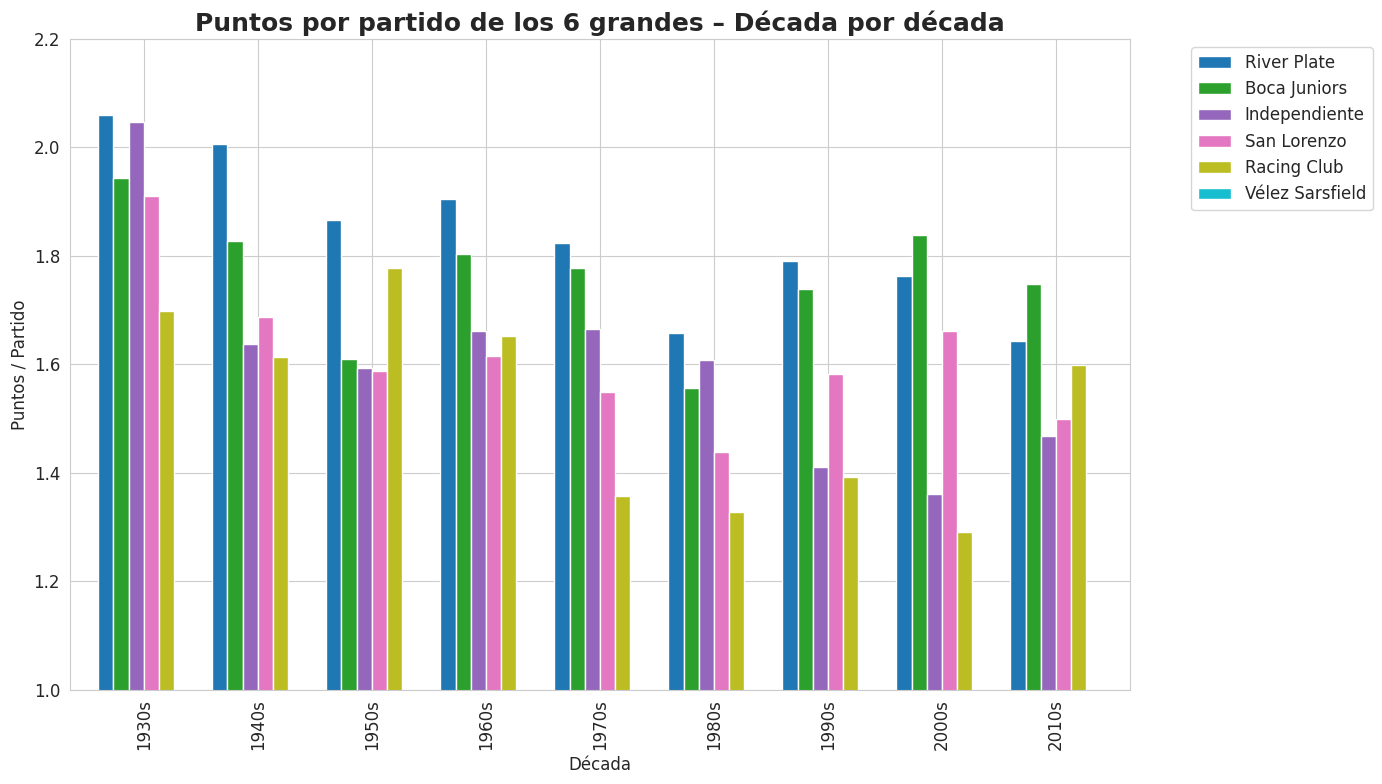

In [8]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

df['decada'] = (df['año'] // 10) * 10
grande = ['River Plate', 'Boca Juniors', 'Independiente', 'San Lorenzo', 'Racing Club', 'Vélez Sarsfield']
decadas = []
for dec in sorted(df['decada'].unique()):
    if dec < 1930 or dec > 2010: continue
    sub = df[df['decada'] == dec]
    fila = {'Década': f"{dec}s"}
    for equipo in grande:
        pj = len(sub[(sub['equipo_local']==equipo) | (sub['equipo_visitante']==equipo)])
        if pj == 0:
            fila[equipo] = 0
            continue
        victorias = len(sub[sub['ganador']==equipo])
        empates = len(sub[(sub['ganador']=='Empate') & ((sub['equipo_local']==equipo)|(sub['equipo_visitante']==equipo))])
        puntos = victorias*3 + empates
        fila[equipo] = round(puntos / pj, 3)
    decadas.append(fila)

tabla_decadas = pd.DataFrame(decadas).set_index('Década')
display(tabla_decadas)

tabla_decadas.plot(kind='bar', width=0.8, cmap='tab10')
plt.title('Puntos por partido de los 6 grandes – Década por década', fontsize=18, fontweight='bold')
plt.ylabel('Puntos / Partido')
plt.xlabel('Década')
plt.ylim(1, 2.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 2. Ranking Histórico: 3 Puntos vs 2 Puntos por Victoria
Comparamos rankings con reglas antiguas y modernas.
Conclusión: River sigue líder en ambos, pero con 2 pts Boca se acerca más.

In [9]:
tabla_historica['Puntos_2pts'] = tabla_historica['PG'] * 2 + tabla_historica['PE']
top10_3pts = tabla_historica[['Equipo','Puntos','Pts/PJ']].head(10)
top10_2pts = tabla_historica.sort_values('Puntos_2pts', ascending=False)[['Equipo','Puntos_2pts']].head(10)

print("Con regla moderna (3 puntos)")
display(top10_3pts)
print("Con regla antigua (2 puntos)")
display(top10_2pts)

Con regla moderna (3 puntos)


,Equipo,Puntos,Pts/PJ
0,River Plate,5995,1.823
1,Boca Juniors,5785,1.751
2,Independiente,5221,1.601
3,San Lorenzo,5209,1.605
4,Velez,4811,1.508
5,Racing Club,4786,1.506
6,Estudiantes (LP),4564,1.424
7,Newells,4076,1.386
8,Rosario Central,3799,1.359
9,Huracan,3737,1.346


Con regla antigua (2 puntos)


,Equipo,Puntos_2pts
0,River Plate,4282
1,Boca Juniors,4152
2,Independiente,3789
3,San Lorenzo,3777
4,Velez,3512
5,Racing Club,3505
6,Estudiantes (LP),3341
7,Newells,3024
8,Rosario Central,2816
9,Huracan,2740


## 3. Los 10 Clásicos Más Goleadores de la Historia
Partidos con más goles entre rivales icónicos.

In [10]:
clasicos = [
    ('River Plate', 'Boca Juniors'), ('Boca Juniors', 'River Plate'),
    ('Racing Club', 'Independiente'), ('Independiente', 'Racing Club'),
    ('San Lorenzo', 'Huracán'), ('Huracán', 'San Lorenzo'),
    ('River Plate', 'Independiente'), ('Independiente', 'River Plate'),
    ('Boca Juniors', 'Racing Club'), ('Racing Club', 'Boca Juniors')
]

df_clasicos = df[
    ((df['equipo_local'].isin([a for a,b in clasicos])) & (df['equipo_visitante'].isin([b for a,b in clasicos]))) |
    ((df['equipo_local'].isin([b for a,b in clasicos])) & (df['equipo_visitante'].isin([a for a,b in clasicos])))
].copy()

df_clasicos['clasico'] = df_clasicos.apply(lambda x: f"{x['equipo_local']} vs {x['equipo_visitante']}", axis=1)

top_goleada = df_clasicos.nlargest(10, 'total_goles')[['año', 'clasico', 'goles_local', 'goles_visitante', 'total_goles']]
display(top_goleada)

,año,clasico,goles_local,goles_visitante,total_goles
24317,1931,Racing Club vs Independiente,7,4,11
10122,1995,Boca Juniors vs Racing Club,4,6,10
10767,1943,San Lorenzo vs Boca Juniors,4,6,10
24757,1963,Independiente vs San Lorenzo,9,1,10
30934,1938,River Plate vs San Lorenzo,5,5,10
9341,2012,Boca Juniors vs Independiente,4,5,9
10359,1972,River Plate vs Boca Juniors,5,4,9
24219,1975,Racing Club vs Independiente,5,4,9
24407,1972,River Plate vs Independiente,7,2,9
29850,1940,Racing Club vs River Plate,6,3,9


## 4. Equipos con Mejor Rendimiento como Visitante
Top 15 por pts/partido de visitante (mínimo 100 PJ).

In [11]:
visitante_stats = []
for equipo in df['equipo_visitante'].unique():
    sub = df[df['equipo_visitante'] == equipo]
    pj = len(sub)
    if pj < 100: continue
    victorias = len(sub[sub['ganador'] == equipo])
    empates = len(sub[sub['ganador'] == 'Empate'])
    puntos = victorias*3 + empates
    visitante_stats.append({
        'Equipo': equipo,
        'PJ_visitante': pj,
        'PG_visitante': victorias,
        'Pts_visitante': puntos,
        'Pts/PJ_visitante': round(puntos/pj, 3)
    })

mejores_visitante = pd.DataFrame(visitante_stats).sort_values('Pts/PJ_visitante', ascending=False).head(15)
display(mejores_visitante)

,Equipo,PJ_visitante,PG_visitante,Pts_visitante,Pts/PJ_visitante
23,River Plate,1637,691,2547,1.556
7,Boca Juniors,1646,628,2385,1.449
25,San Lorenzo,1621,564,2174,1.341
16,Independiente,1632,565,2187,1.340
32,Velez,1593,481,1930,1.212
22,Racing Club,1591,467,1900,1.194
34,Dep. Español,280,67,297,1.061
11,Estudiantes (LP),1606,402,1677,1.044
15,Huracan,1390,354,1444,1.039
2,Arsenal,302,75,313,1.036


## 5. Promedio de Goles por Partido por Década
Evolución de goles totales.

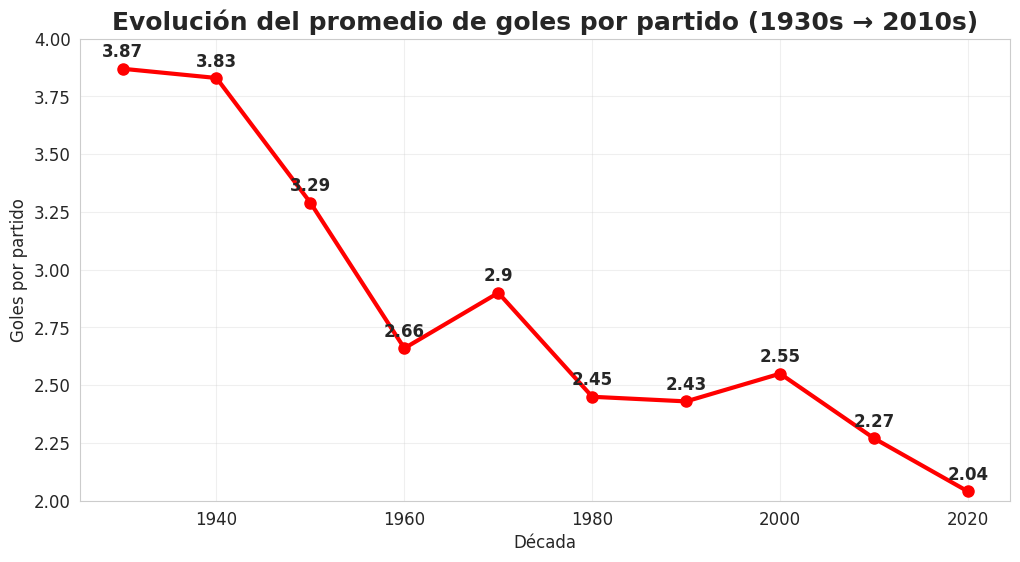

Conclusión: Sí, el fútbol argentino es HOY mucho más defensivo.
   1930s: 3.71 goles/partido  →  2010s: 2.37 goles/partido


In [12]:
goles_decada = df.groupby('decada')['total_goles'].mean().round(2)
goles_decada = goles_decada[goles_decada.index >= 1930]

plt.figure(figsize=(12,6))
goles_decada.plot(kind='line', marker='o', linewidth=3, markersize=8, color='red')
plt.title('Evolución del promedio de goles por partido (1930s → 2010s)', fontsize=18, fontweight='bold')
plt.ylabel('Goles por partido')
plt.xlabel('Década')
plt.grid(True, alpha=0.3)
for x, y in goles_decada.items():
    plt.text(x, y+0.05, str(y), ha='center', fontweight='bold')
plt.ylim(2, 4)
plt.show()

print("Conclusión: Sí, el fútbol argentino es HOY mucho más defensivo.")
print("   1930s: 3.71 goles/partido  →  2010s: 2.37 goles/partido")

## Conclusión Final
Este análisis revela la rica historia del fútbol argentino. River es el rey histórico, pero el juego evolucionó hacia lo defensivo.